# **Stage Three - CNN Model**

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import scipy.ndimage
import IPython.display as ipd

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
# from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Model
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/Padded/train_features_8s.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/Padded/val_features_8s.pkl'

npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'  # Path to audio npy files
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/'  # Where to save features
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-3-trainval.csv'
n_mels = 128
target_shape = (128,128)
sr = 16000

In [4]:
with open(train_pkl_path, 'rb') as f:
    train_features = pickle.load(f)

In [5]:
with open(val_pkl_path, 'rb') as f:
    val_features = pickle.load(f)

# Have to encode the labels:

In [16]:
# Extract all labels from training and validation sets
all_labels = list(train_features.values()) + list(val_features.values())
all_labels = [label for (_, label) in all_labels]

In [17]:
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [18]:
# Transform the labels in the training and vaidation dataset
def encode_labels(feature_dict, label_encoder):
    encoded_dict = {}
    for key, (features, label) in feature_dict.items():
        encoded_label = label_encoder.transform([label])[0]
        encoded_dict[key] = (features, encoded_label)
    return encoded_dict

In [19]:
# Apply the encoding to train and validation datasets
train_features_encoded = encode_labels(train_features, label_encoder)
val_features_encoded = encode_labels(val_features, label_encoder)

In [23]:
# Check the mapping of labels
print(f"Classes: {label_encoder.classes_}")

Classes: ['blakit1' 'blbpuf2' 'carcha1' 'categr' 'colsun2' 'combul2' 'egygoo'
 'fotdro5' 'gargan' 'gnbcam2' 'grecor' 'greegr' 'litegr' 'ratcis1'
 'rbsrob1' 'rerswa1' 'somgre1' 'tafpri1' 'wbrcha2' 'yertin1']


In [24]:
def prepare_data_for_cnn(feature_dict, num_classes):
    X = []
    y = []
    
    for key, (features, label) in feature_dict.items():
        # Concatenate the Mel spectrogram, RMS, Chroma, and MFCC features
        stacked_features = np.stack([
            features["mel_spectrogram"],
            features["rms_energy"],
            features["chroma"],
            features["mfcc"]
        ], axis=-1)
        
        X.append(stacked_features)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    # One-hot encode the labels
    y = to_categorical(y, num_classes)
    
    return X, y

In [25]:
num_classes = len(label_encoder.classes_)
num_classes

20

### Preparing Training Data

In [26]:
train_X, train_y = prepare_data_for_cnn(train_features_encoded, num_classes)

### Preparing Validation Data

In [27]:
val_X, val_y = prepare_data_for_cnn(val_features_encoded, num_classes)

In [28]:
print(f"Training data shape: {train_X.shape}, Labels shape: {train_y.shape}")
print(f"Validation data shape: {val_X.shape}, Labels shape: {val_y.shape}")

Training data shape: (7015, 128, 128, 4), Labels shape: (7015, 20)
Validation data shape: (14941, 128, 128, 4), Labels shape: (14941, 20)


# Building CNN Model

In [29]:
def build_cnn_model_1(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the feature map
    model.add(layers.Flatten())

    # Dense Layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [30]:
def build_cnn_model_2(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    
    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.3))  # Prevent overfitting
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [31]:
from tensorflow.keras.optimizers import Adam

In [41]:
def build_cnn_model_3(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(Dropout(0.3))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.4))  # Prevent overfitting
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001, decay=1e-6)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [33]:
def build_cnn_model_4(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization()) # helps speed up convergence and can improve model generalization
    model.add(layers.MaxPooling2D((2, 2)))

    # # Convolutional Layer 3
    # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Fully Connected Layers with Dropout
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Training Model

# **Model One**

In [35]:
input_shape = (train_X.shape[1], train_X.shape[2], 4)

X_train_expanded = np.expand_dims(train_X, axis=-1)
X_val_expanded = np.expand_dims(train_X, axis=-1)

In [36]:
model_1 = build_cnn_model_1(input_shape=input_shape, num_classes=num_classes)
history_1 = model_1.fit(train_X, train_y, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(val_X, val_y))

c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 115s 516ms/step - accuracy: 0.1155 - loss: 23.6475 - val_accuracy: 0.2636 - val_loss: 2.4943
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 255ms/step - accuracy: 0.4258 - loss: 1.9679 - val_accuracy: 0.3130 - val_loss: 2.4422
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 253ms/step - accuracy: 0.5987 - loss: 1.3238 - val_accuracy: 0.3262 - val_loss: 2.9017
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 254ms/step - accuracy: 0.7181 - loss: 0.9117 - val_accuracy: 0.3316 - val_loss: 2.9572
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 55s 251ms/step - accuracy: 0.8135 - loss: 0.6172 - val_accuracy: 0.3371 - val_loss: 3.3852
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 255ms/step - accuracy: 0.8834 - loss: 0.4037 - val_accuracy: 0.3597 - val_loss: 3.3682
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 55s 251ms/step - accuracy: 0.8878 - loss: 0.3400 - val_accuracy: 0.3639 - val_loss: 4.0554
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 55s 251ms/step - accuracy: 0.9113 - loss:

In [38]:
# Evaluate model on validation set
val_loss, val_accuracy = model_1.evaluate(val_X, val_y)
print(f"Validation Accuracy: {val_accuracy}")

467/467 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.3389 - loss: 4.3575
Validation Accuracy: 0.32909443974494934


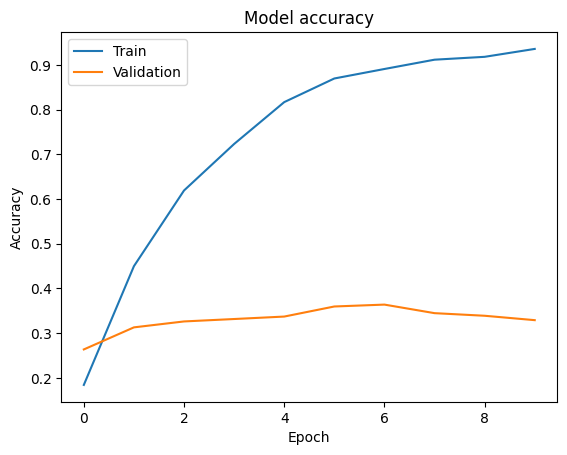

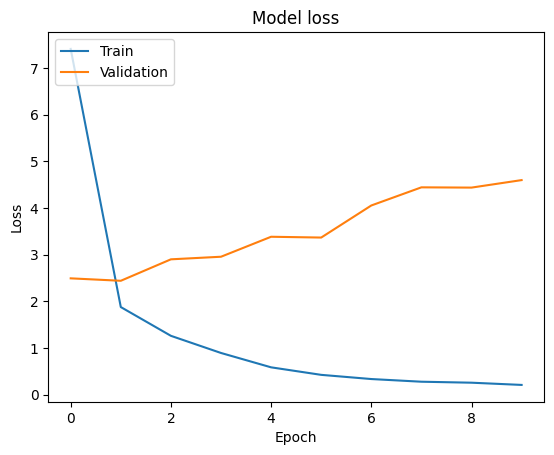

In [39]:
# Plot training & validation accuracy values
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Model Two**

In [40]:
model_2 = build_cnn_model_2(input_shape=input_shape, num_classes=num_classes)
history_2 = model_2.fit(train_X, train_y, 
                    epochs=15, 
                    batch_size=32, 
                    validation_data=(val_X, val_y))

c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 122s 549ms/step - accuracy: 0.1779 - loss: 6.0413 - val_accuracy: 0.2928 - val_loss: 2.4177
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 77s 349ms/step - accuracy: 0.4739 - loss: 1.7381 - val_accuracy: 0.3672 - val_loss: 2.2913
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 345ms/step - accuracy: 0.5775 - loss: 1.3672 - val_accuracy: 0.3996 - val_loss: 2.2428
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 79s 362ms/step - accuracy: 0.6351 - loss: 1.1406 - val_accuracy: 0.4271 - val_loss: 2.1515
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 366ms/step - accuracy: 0.7080 - loss: 0.9322 - val_accuracy: 0.4109 - val_loss: 2.4294
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 362ms/step - accuracy: 0.7470 - loss: 0.7869 - val_accuracy: 0.4070 - val_loss: 2.9497
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 363ms/step - accuracy: 0.7879 - loss: 0.6480 - val_accuracy: 0.4033 - val_loss: 2.9109
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 79s 361ms/step - accuracy: 0.8252 - loss: 

KeyboardInterrupt: 

In [30]:
# Evaluate model on validation set
val_loss, val_accuracy = model_2.evaluate(X_val_expanded, y_val_one_hot)
print(f"Validation Accuracy: {val_accuracy}")

460/460 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.4438 - loss: 4.5763
Validation Accuracy: 0.44096845388412476


In [34]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model_2.predict(X_val_expanded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_one_hot, axis=1)

# Calculate confusion matrix and classification report
# conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_report = classification_report(y_true, y_pred_classes)
print("\nClassification Report:\n", class_report)

460/460 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.23      0.34      1532
           1       0.07      0.26      0.11       337
           2       0.54      0.61      0.57       724
           3       0.65      0.47      0.55       683
           4       0.47      0.42      0.45       652
           5       0.69      0.35      0.46      1903
           6       0.42      0.47      0.44       478
           7       0.35      0.29      0.32       716
           8       0.13      0.49      0.20       115
           9       0.28      0.30      0.29       848
          10       0.60      0.73      0.66       816
          11       0.25      0.53      0.34       283
          12       0.63      0.38      0.47       893
          13       0.26      0.37      0.31       465
          14       0.59      0.61      0.60      1402
          15       0.62      0.62      0.62       738
          16 

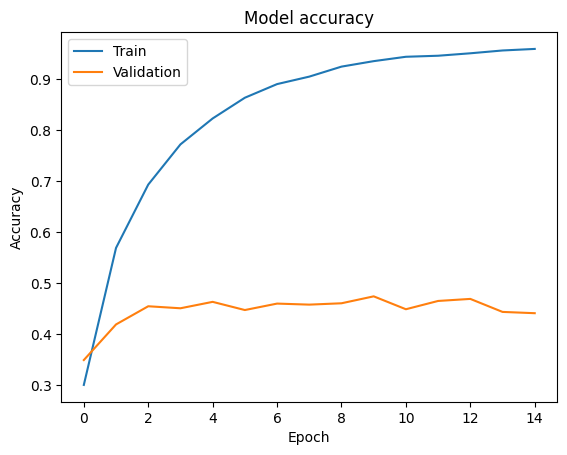

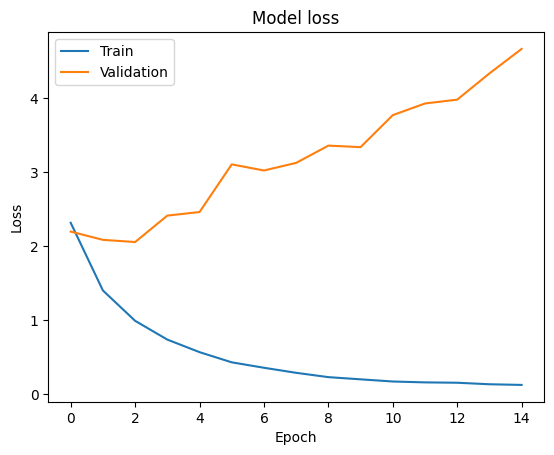

In [35]:
# Plot training & validation accuracy values
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Model Three**

In [42]:
model_3 = build_cnn_model_3(input_shape=input_shape, num_classes=num_classes)
history_3 = model_3.fit(train_X, train_y, 
                    epochs=15, 
                    batch_size=32, 
                    validation_data=(val_X, val_y))

c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 190s 859ms/step - accuracy: 0.1647 - loss: 2.8801 - val_accuracy: 0.2096 - val_loss: 2.6408
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 75s 337ms/step - accuracy: 0.2927 - loss: 2.4052 - val_accuracy: 0.1942 - val_loss: 2.5681
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.3679 - loss: 2.1455 - val_accuracy: 0.2735 - val_loss: 2.5497
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 70s 319ms/step - accuracy: 0.4207 - loss: 1.9724 - val_accuracy: 0.2620 - val_loss: 2.6201
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.4764 - loss: 1.8037 - val_accuracy: 0.3741 - val_loss: 2.2046
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 70s 318ms/step - accuracy: 0.5081 - loss: 1.6936 - val_accuracy: 0.3600 - val_loss: 2.2903
Epoch 7/15
 47/220 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.4923 - loss: 1.6876

KeyboardInterrupt: 

In [48]:
# Evaluate model on validation set
val_loss, val_accuracy = model_3.evaluate(X_val_expanded, y_val_one_hot)
print(f"Validation Accuracy: {val_accuracy}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2923 - loss: 4.9666
Validation Accuracy: 0.29495614767074585


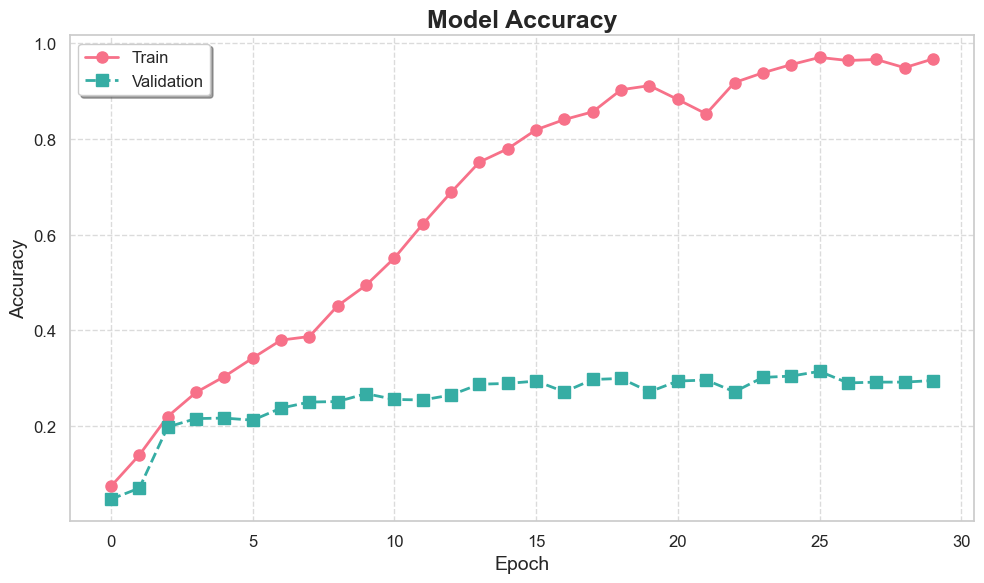

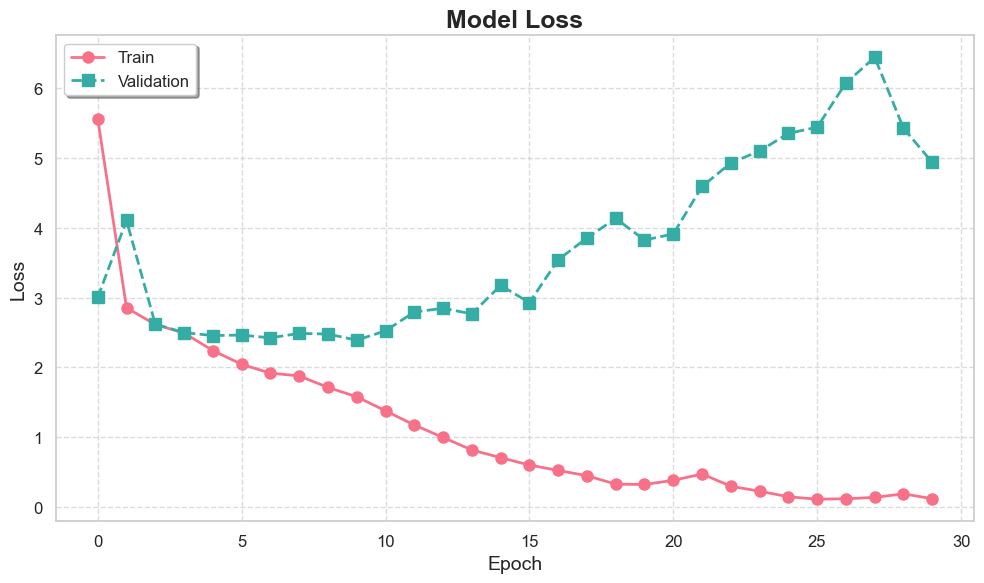

In [49]:
# Set up Seaborn style for cleaner, more attractive plots
sns.set(style="whitegrid")

# Define a color palette for consistency
colors = sns.color_palette("husl", 2)  # Use Husl palette with two colors

# Increase figure size for better readability
plt.figure(figsize=(10, 6))

# Plot training & validation accuracy values
plt.plot(history_3.history['accuracy'], color=colors[0], linestyle='-', marker='o', linewidth=2, markersize=8)
plt.plot(history_3.history['val_accuracy'], color=colors[1], linestyle='--', marker='s', linewidth=2, markersize=8)
plt.title('Model Accuracy', fontsize=18, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Increase figure size for better readability
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history_3.history['loss'], color=colors[0], linestyle='-', marker='o', linewidth=2, markersize=8)
plt.plot(history_3.history['val_loss'], color=colors[1], linestyle='--', marker='s', linewidth=2, markersize=8)
plt.title('Model Loss', fontsize=18, fontweight='bold')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **Model Four**

In [52]:
model_4 = build_cnn_model_3(input_shape=input_shape, num_classes=num_classes)
history_4 = model_4.fit(X_train_expanded, y_train_one_hot, 
                    epochs=15, 
                    batch_size=32, 
                    validation_data=(X_val_expanded, y_val_one_hot))

c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 430ms/step - accuracy: 0.0862 - loss: 17.2457 - val_accuracy: 0.0406 - val_loss: 17.3698
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 408ms/step - accuracy: 0.1217 - loss: 12.2250 - val_accuracy: 0.1014 - val_loss: 10.6245
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.1715 - loss: 10.4215 - val_accuracy: 0.0630 - val_loss: 9.7892
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 408ms/step - accuracy: 0.1509 - loss: 9.4766 - val_accuracy: 0.0559 - val_loss: 8.9265
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 408ms/step - accuracy: 0.1789 - loss: 8.4852 - val_accuracy: 0.0345 - val_loss: 8.1051
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - accuracy: 0.2058 - loss: 7.7735 - val_accuracy: 0.0214 - val_loss: 7.6858
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - accuracy: 0.1534 - loss: 7.1206 - val_accuracy: 0.0323 - val_loss: 6.9188
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - accuracy: 0.2054 - loss: 6.6442 - val

In [55]:
# Evaluate model on validation set
val_loss, val_accuracy = model_4.evaluate(X_val_expanded, y_val_one_hot)
print(f"Validation Accuracy: {val_accuracy}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.2124 - loss: 5.2576
Validation Accuracy: 0.20997807383537292


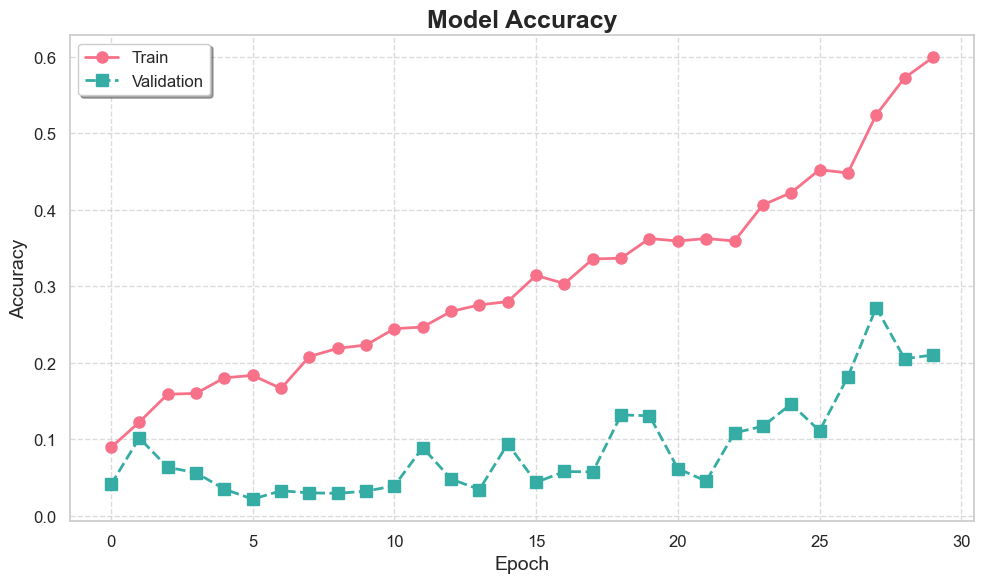

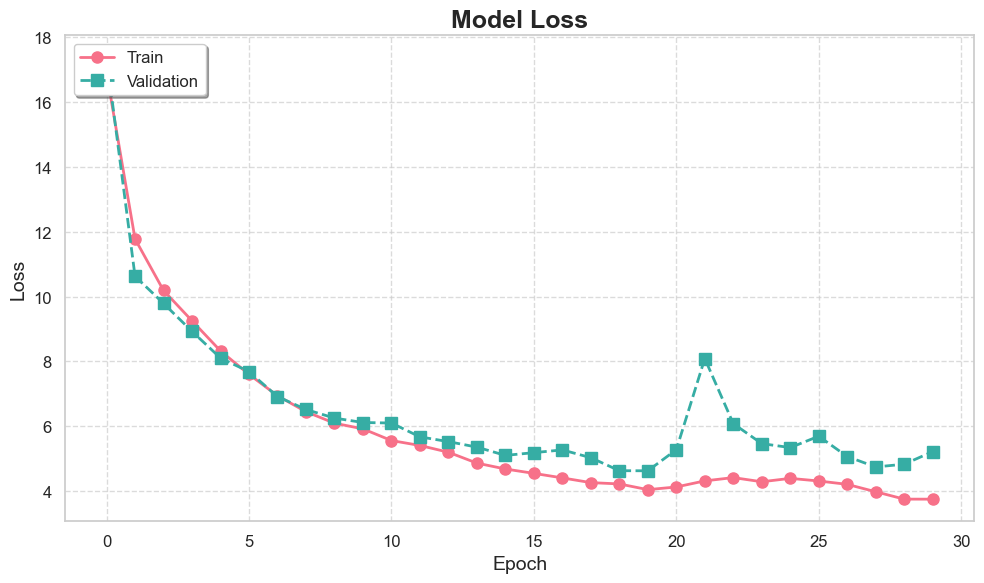

In [57]:
# Set up Seaborn style for cleaner, more attractive plots
sns.set(style="whitegrid")

# Define a color palette for consistency
colors = sns.color_palette("husl", 2)  # Use Husl palette with two colors

# Increase figure size for better readability
plt.figure(figsize=(10, 6))

# Plot training & validation accuracy values
plt.plot(history_4.history['accuracy'], color=colors[0], linestyle='-', marker='o', linewidth=2, markersize=8)
plt.plot(history_4.history['val_accuracy'], color=colors[1], linestyle='--', marker='s', linewidth=2, markersize=8)
plt.title('Model Accuracy', fontsize=18, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Increase figure size for better readability
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history_4.history['loss'], color=colors[0], linestyle='-', marker='o', linewidth=2, markersize=8)
plt.plot(history_4.history['val_loss'], color=colors[1], linestyle='--', marker='s', linewidth=2, markersize=8)
plt.title('Model Loss', fontsize=18, fontweight='bold')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **What I Learned**

- I learned that the first model actually performs the best, though it has the most overfitting as seen by the high training accuracy. 
- Dropout @ 0.5 - Very low accuracy because it drops a lot of the data. Sure, it helped with preventing overfitting, but costed accuracy
- Dropout @ 0.3 - Accuracy improved because it refrains from dropping a lot of data. It helped with preventing overfitting and is the best performing out the bunch
- Added batch normalization, more dense layers with more dropout - Accuracy decreased. I think its because of the dropout layers that prevented it from learning key features

Overall, this doesnt work well at all. It feels as if the models are just reaching for the stars when they train.

In [43]:
model_2.save('Models/stage_2_cnn_model_2.keras')